# Upper ocean effects of windmill farms at sea - Sørvest F 
### Kjersti Stangeland - Summer 2025 - The Norwegian Meteorological Insitute

#### The project

A scenario with Norwegian wind farms at sea has been developed in a collaboration with NVE. The period 2/2-2022 til 30/6-2022 is simulated with MEPS, WaveWatch III, og Norkyst v3. There are to versions of the simulations:
* A control run based of the current situation with no Norwegian wind farms at sea
* An experiment with simulated wind farms.

In the experiments, the only direct parametrization of the windmills are in MEPS. Therefore, effects on waves and ocean cirulation is indirectly seen through changed surface fluxes.

__Details on the wind farms:__
* Height of turbines is 165 m
* Radius 143 m
* 2.5 km distance between turbines
* 6 (?) different farms along the Norwegian coast

__Sørvest F__
* A wind farm south west of Norway
* 3 x ? turbines

### Calculation of mean internal Rossby radius

To investigate the impact of wind farms at sea it is useful to make the study area smaller, i.e. not use the whole model domain. The Rossby radius or deformation radius allows us to delimit the area safely while making sure that the relevant dynamics are still within the domain. By taking 1-2 deformation radii as our domain of investigation around the wind farm, we're making sure that the internal dynamics are dominated by internal baroclinic instabilities. As the radius is telling about the length of deformation of a wave, that is a length scaale where the rotation of Earth affects the currents and geostrophy dominates.

Sperrevik et al. (2017) calculated the internal Rossby radii using the following method.

$$R_1 = \frac{c_1}{\mid f \mid}$$
where $f$ is the local Coriolis parameter and $c_1$ the phase speed of a first mode baroclinic gravity wave. The phase speed can be solved as an eigenvalue problem, but we will deploy the method of Chelton et al. (1998) and use the WKB-approximation.
$$R_1 \approx R_1^{WKB} = \frac{1}{\mid f \mid \pi}\int_{-H}^{0}N(z) dz$$

Here, $H$ is the local water depth and $N$ the buoyancy frequency. Sperrevik et al. (2017) calculated the radius for an area in Northern Norway, Lofoten, as shown in the figure below.

<p align="center">
  <img src="Sperrevik_etal_2017_fig5.png" alt="Sperrevik et al. (2017)">
</p>

Here we have the internal deformation radius for the spring months of 1984. The radii has its minimum after the winter and increases towards the summer due to a stronger stratification developing. I will use this figure as a reference to see if the values I compute are reasonable.

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import xarray as xr
import cmocean.cm as cmo
import cartopy.crs as ccrs
import pandas as pd
from roppy import SGrid

import warnings
warnings.filterwarnings("ignore")

In [ ]:
path = '/home/kjsta7412/sommer_25/MET_sommer25/output_bdr/tests/norkyst_avg_0001DENSITY_USED.nc'
ds_density = xr.open_dataset(path)

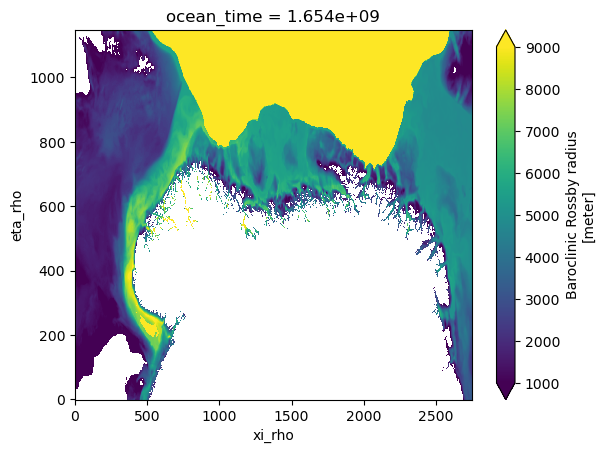

In [ ]:
ds_density.gamma_r.isel(ocean_time=0).plot()

The above is calculated with the density given from the datasets. I believe the density is not potential density as there are huge values of rossby radii out of the continental shelf. So when integrating from 3000 m and up the values grow very large when the density is not potential.

In [ ]:
path0 = '/home/kjsta7412/sommer_25/MET_sommer25/output_bdr/tests/norkyst_avg_0001ANNKS_METHOD.nc'
ds_annks = xr.open_dataset(path0)

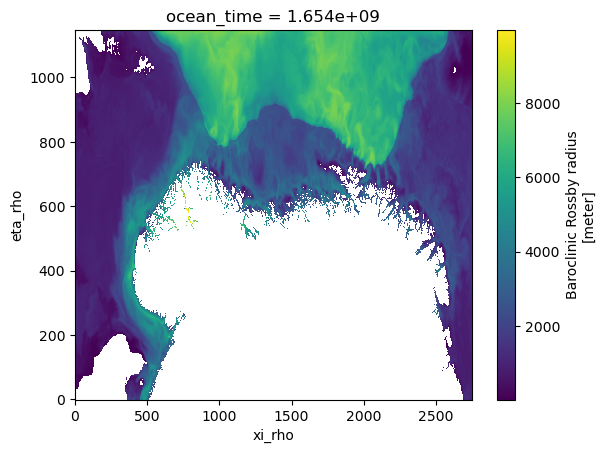

In [5]:
ds_annks.gamma_r.isel(ocean_time=0).plot()

Here the same is caclulated, but with getting the density from potential temperature and salt from the dataset. The values here are more physical and reasonable according to literature as well.

In [8]:
from roppy import SGrid
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from roppy import SGrid
from netCDF4 import Dataset
import numpy as np
from scipy.interpolate import griddata
from glob import glob
from N2 import N2
import time
from density import dens

In [9]:
path1 = '/lustre/storeB/project/nwp/havvind/hav/results/experiment/EXP-06/norkyst_avg_0001.nc'
ds1 = Dataset(path1)

In [10]:
ds_xr = xr.open_dataset(path1)

In [11]:
grid = SGrid(ds1)

In [12]:
zlevs = np.arange(0,51,1)
zlevs = np.insert(zlevs,len(zlevs),values=np.arange(52,102,2), axis =0)
zlevs = np.insert(zlevs,len(zlevs),values=np.arange(105,305,5), axis =0)
zlevs = np.insert(zlevs,len(zlevs),values=np.arange(520,1020,20), axis =0)
zlevs = np.insert(zlevs,len(zlevs),values=np.arange(1050,3050,50), axis =0)

zlevs = zlevs[np.where(zlevs<=np.max(grid.h))]
zlevs = np.array(zlevs)*-1.

In [13]:
zlevs[0]

-0.0

In [14]:
np.shape(grid.z_r)

(40, 1148, 2747)

In [15]:
z_r_as_in_ds = grid.z_r

In [16]:
z_r_as_in_ds[:, 0, 0]

array([-9.80927816, -9.42583196, -9.03885101, -8.64865513, -8.256912  ,
       -7.86612477, -7.47905935, -7.09829287, -6.72594702, -6.36358874,
       -6.01224658, -5.67249004, -5.3445318 , -5.02832815, -4.72366534,
       -4.43022761, -4.14764751, -3.87554096, -3.61353033, -3.36125854,
       -3.11839677, -2.88464785, -2.65974679, -2.44345956, -2.23558081,
       -2.03593121, -1.84435456, -1.66071492, -1.48489395, -1.31678848,
       -1.15630832, -1.00337433, -0.85791675, -0.71987378, -0.58919034,
       -0.46581709, -0.34970954, -0.24082737, -0.1391339 , -0.04459563])

In [17]:
# Depth of rho-points
z_r = np.insert(grid.z_r, grid.z_r.shape[0], values = np.zeros_like(grid.h), axis=0)  # Adding 0 to end of array

In [18]:
z_r[:, 0, 0]

array([-9.80927816, -9.42583196, -9.03885101, -8.64865513, -8.256912  ,
       -7.86612477, -7.47905935, -7.09829287, -6.72594702, -6.36358874,
       -6.01224658, -5.67249004, -5.3445318 , -5.02832815, -4.72366534,
       -4.43022761, -4.14764751, -3.87554096, -3.61353033, -3.36125854,
       -3.11839677, -2.88464785, -2.65974679, -2.44345956, -2.23558081,
       -2.03593121, -1.84435456, -1.66071492, -1.48489395, -1.31678848,
       -1.15630832, -1.00337433, -0.85791675, -0.71987378, -0.58919034,
       -0.46581709, -0.34970954, -0.24082737, -0.1391339 , -0.04459563,
        0.        ])

In [19]:
np.shape(z_r)

(41, 1148, 2747)

In [20]:
z_r = np.insert(z_r, 0, values = -1.*grid.h, axis=0)  # Adding local water depth to start of array

In [21]:
z_r[:, 0, 0]

array([-10.        ,  -9.80927816,  -9.42583196,  -9.03885101,
        -8.64865513,  -8.256912  ,  -7.86612477,  -7.47905935,
        -7.09829287,  -6.72594702,  -6.36358874,  -6.01224658,
        -5.67249004,  -5.3445318 ,  -5.02832815,  -4.72366534,
        -4.43022761,  -4.14764751,  -3.87554096,  -3.61353033,
        -3.36125854,  -3.11839677,  -2.88464785,  -2.65974679,
        -2.44345956,  -2.23558081,  -2.03593121,  -1.84435456,
        -1.66071492,  -1.48489395,  -1.31678848,  -1.15630832,
        -1.00337433,  -0.85791675,  -0.71987378,  -0.58919034,
        -0.46581709,  -0.34970954,  -0.24082737,  -0.1391339 ,
        -0.04459563,   0.        ])

In [22]:
np.shape(z_r)

(42, 1148, 2747)

In [23]:
# Variables
ocean_time = ds1.variables['ocean_time']
density = ds1.variables['rho'][:]
salt  = ds1.variables['salt'][:]
temp = ds1.variables['temp'][:]
f = ds1.variables['f'][:]
h = grid.h[:,:]
mask = grid.mask_rho[:,:]

In [24]:
tmpn = np.ones([1, density.shape[2], density.shape[3]])*np.nan  # Temporary array holding buoyancy frequency
tmpr = np.ones([1, density.shape[2], density.shape[3]])*np.nan  # Temporary array holding Rossby radius

In [25]:
np.shape(tmpn)

(1, 1148, 2747)

In [26]:
# Looping through grid points
for y in range(0, density.shape[2]):
    for x in range(0, density.shape[3]): 
        if not mask[y, x]:  # skipping land points
            continue

        tmpn[0,y,x] = 0
        # Filtering out local water depth on the zlevs
        # Where zlevs is shallower than z_r -> true
        tmpnz = zlevs[np.where(zlevs[:]>z_r[:,y,x].min())].squeeze()  # z-levels to calculate N on
        N_depth = (tmpnz[0:-1] + tmpnz[1:])/2.  # Midpoints between z-levels

        if 1:
            t = -1
            tmpnS = salt[t,:,y,x]; tmpnS = np.append(tmpnS,tmpnS[-1]); tmpnS = np.insert(tmpnS,0,values=tmpnS[0],axis=0)
            tmpnT = temp[t,:,y,x]; tmpnT = np.append(tmpnT,tmpnT[-1]); tmpnT = np.insert(tmpnT,0,values=tmpnT[0],axis=0)
            tempZ = griddata(z_r[:,y,x], tmpnT[:], tmpnz)
            saltZ = griddata(z_r[:,y,x], tmpnS[:], tmpnz)

            tmpD =  density[t, :, y, x]
            tmpD = np.append(tmpD, tmpD[-1]); tmpD = np.insert(tmpD, 0, values=tmpD[0], axis=0)
            #densZ = griddata(z_r[:, y, x], tmpD[:], tmpnz) 

            densm = dens(saltZ, tempZ, np.zeros_like(tempZ)).squeeze()

In [27]:
densZ = griddata(z_r[:, y, x], tmpD[:], tmpnz)

In [28]:
densZ = densZ+1000

In [29]:
np.shape(densZ)

(83,)

In [30]:
np.shape(densm)

(83,)

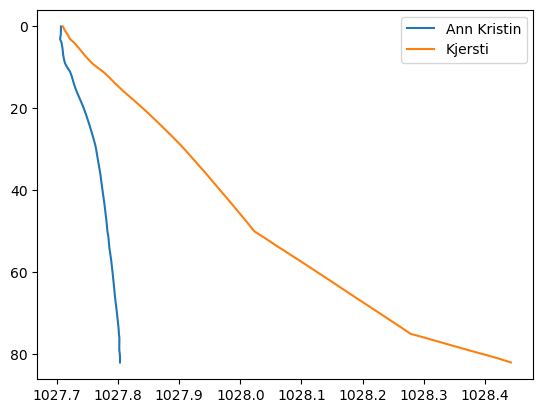

In [41]:
plt.plot(densm, range(len(densm)), label='Ann Kristin')
plt.plot(densZ, range(len(densZ)), label='Kjersti') 
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [32]:
n2 = N2(densZ, tmpnz); n2[np.where(n2<0)] = 0.0000001; N_kj = np.sqrt(n2).squeeze()

In [33]:
n2 = N2(densm, tmpnz);  n2[np.where(n2<0)] = 0.0000001; N_ak = np.sqrt(n2).squeeze()

In [34]:
N_kj

array([0.00576411, 0.00662385, 0.00583317, 0.00845361, 0.00760955,
       0.00738366, 0.00730759, 0.00761964, 0.00799279, 0.00903496,
       0.00948682, 0.00846658, 0.00812385, 0.00803265, 0.00834388,
       0.00847561, 0.00866179, 0.00867685, 0.00868895, 0.00853266,
       0.0084012 , 0.00835613, 0.00828   , 0.00827845, 0.00817747,
       0.00817747, 0.0081214 , 0.00805288, 0.00805288, 0.00775132,
       0.00759198, 0.00759198, 0.00762466, 0.00764493, 0.00764493,
       0.00758615, 0.00744024, 0.00744024, 0.00744024, 0.00747089,
       0.00748729, 0.00748729, 0.00748729, 0.00742016, 0.00738622,
       0.00738622, 0.00738622, 0.00734838, 0.00726025, 0.00726025,
       0.00726025, 0.00708224, 0.00702635, 0.00704877, 0.00716706,
       0.00716706, 0.00714087, 0.00708586, 0.00708586, 0.00707858,
       0.00705778, 0.00705778, 0.00705778, 0.00703572, 0.00703514,
       0.00703514, 0.00706011, 0.00708568, 0.00708568, 0.00708568,
       0.00705296, 0.00704762, 0.00704762, 0.0070281 , 0.00691

In [35]:
N_ak

array([0.00012894, 0.00031623, 0.00031623, 0.00499363, 0.00338896,
       0.00283963, 0.00263888, 0.00340957, 0.00417393, 0.00593899,
       0.00658124, 0.00504877, 0.00442855, 0.00424614, 0.00479686,
       0.00500687, 0.00529751, 0.00532054, 0.00533422, 0.00508236,
       0.0048675 , 0.00478566, 0.00466288, 0.00464256, 0.00448488,
       0.00446867, 0.00436511, 0.00424209, 0.00422811, 0.00363603,
       0.00329366, 0.00328916, 0.0033665 , 0.00341289, 0.00340951,
       0.00327618, 0.0029311 , 0.00292921, 0.00292731, 0.00300442,
       0.00304422, 0.00304244, 0.00304066, 0.00287776, 0.00279239,
       0.0027916 , 0.00279081, 0.00269177, 0.00244949, 0.00244939,
       0.00244924, 0.00189934, 0.00168792, 0.00177488, 0.00220392,
       0.00220045, 0.00212117, 0.00194765, 0.00194094, 0.00191543,
       0.0018541 , 0.00184753, 0.00184095, 0.00179337, 0.00178337,
       0.00177439, 0.00189505, 0.00200926, 0.00199793, 0.00198655,
       0.00190961, 0.00188606, 0.00187325, 0.00179038, 0.00127

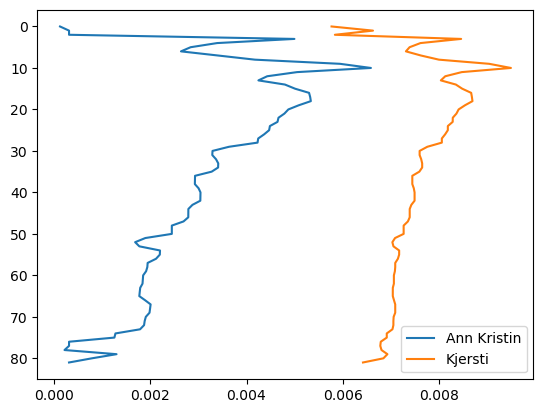

In [43]:
plt.plot(N_ak, range(len(N_ak)), label='Ann Kristin')
plt.plot(N_kj, range(len(N_kj)), label='Kjersti')
plt.legend()
plt.gca().invert_yaxis()

In [44]:
ds_xr.temp

<xarray.DataArray 'temp' (ocean_time: 1, s_rho: 40, eta_rho: 1148, xi_rho: 2747)>
[126142240 values with dtype=float32]
Coordinates:
  * s_rho       (s_rho) float64 -0.9799 -0.9403 -0.9014 ... -0.01529 -0.004904
    lon_rho     (eta_rho, xi_rho) float64 ...
    lat_rho     (eta_rho, xi_rho) float64 ...
  * ocean_time  (ocean_time) datetime64[ns] 2022-06-01T12:00:00
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  time-averaged potential temperature
    units:      Celsius
    time:       ocean_time
    grid:       grid
    location:   face
    field:      temperature, scalar, series

Above: tried to understand Ann Kristins scripts. Figured out why computing with the density given from the dataset did not work, its because (or I think) that the density given is not potential density, whereas when computing density using the module of Bjørn Ådlandsvik you get the potential density. I did in the end understandf the script, so I tried to add some explanations in the file find_deformation_radius.py.

Note: N2.py is from Ann Kristin Sperrevik, density.py is from Bjørn Ådlandsvik and find_deformation_radius.py is slightly modified from Ann Kristin Sperrevik.

Below:

Some final modifications to the scripts. I want the time stamps to be correct

In [73]:
path = '/home/kjsta7412/sommer_25/MET_sommer25/output_bdr/tests/testsnorkyst_avg_0001_soonfinal_test.nc'
ds_test = xr.open_dataset(path)

In [74]:
ds_timetesting = Dataset(path)

In [59]:
ds_test.ocean_time.values

array([1.6540848e+09])

In [71]:
ds1.variables['ocean_time']

<class 'netCDF4._netCDF4.Variable'>
float64 ocean_time(ocean_time)
    long_name: averaged time since initialization
    units: seconds since 1970-01-01 00:00:00
    calendar: proleptic_gregorian
    field: time, scalar, series
unlimited dimensions: ocean_time
current shape = (1,)
filling off

In [54]:
ds_xr.ocean_time.values

array(['2022-06-01T12:00:00.000000000'], dtype='datetime64[ns]')

In [60]:
from datetime import timedelta, datetime

In [61]:
ref = datetime(1970, 1, 1)
date = datetime(2022, 6, 1)

In [97]:
ds_timetesting.variables['ocean_time'][0]

masked_array(data=1.6540848e+09,
             mask=False,
       fill_value=1e+20)

In [ ]:
ref = datetime(1970, 1, 1)
date = pd.to_datetime(ref + timedelta(seconds=ds_test.ocean_time.values[0]))

In [105]:
ocean_time = ds_timetesting.variables['ocean_time']
ocean_time = np.array(ocean_time)

In [106]:
ocean_time[0]

1654084800.0

In [107]:
ref = datetime(1970, 1, 1)
date = pd.to_datetime(ref + timedelta(seconds=ocean_time[0]))

In [108]:
ds_timetesting.variables['ocean_time'] = date

In [110]:
ds_timetesting.variables['ocean_time']

Timestamp('2022-06-01 12:00:00')

In [104]:
ds_test.ocean_time.values

array([1.6540848e+09])

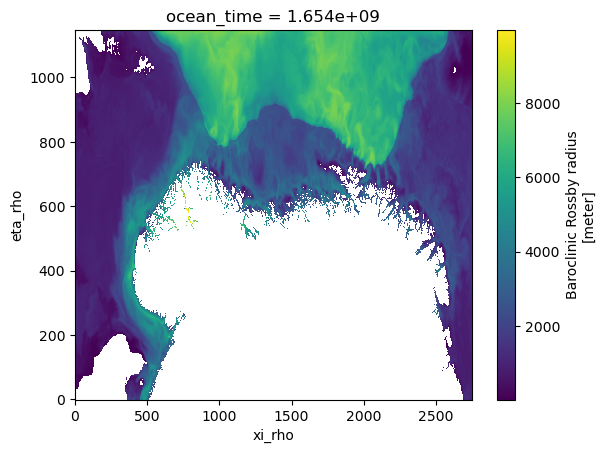

In [72]:
ds_test.gamma_r.isel(ocean_time=0).plot()

In [113]:
path = '/home/kjsta7412/sommer_25/MET_sommer25/output_bdr/tests/norkyst_avg_0001_test_send_to_ppi01.nc'
ds = xr.open_dataset(path)

In [114]:
ds

<xarray.Dataset>
Dimensions:     (ocean_time: 1, eta_rho: 1148, xi_rho: 2747)
Coordinates:
  * ocean_time  (ocean_time) float64 1.654e+09
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    bvf         (ocean_time, eta_rho, xi_rho) float64 ...
    gamma_r     (ocean_time, eta_rho, xi_rho) float64 ...

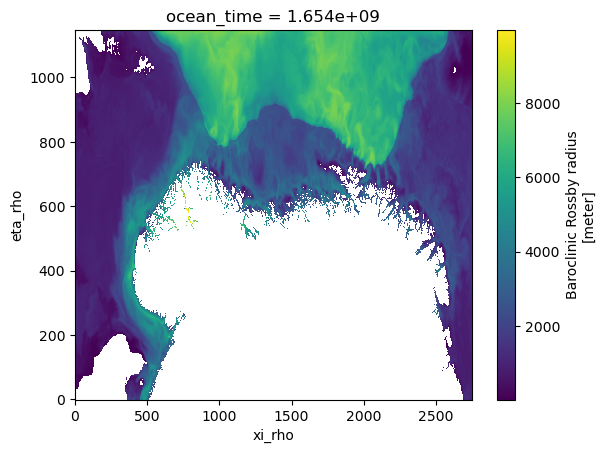

In [115]:
ds.gamma_r.isel(ocean_time=0).plot()

In [139]:
p = '/home/kjsta7412/sommer_25/MET_sommer25/output_bdr/tests/REF_06_norkyst_avg_0001_brr.nc'
x = xr.open_dataset(p)

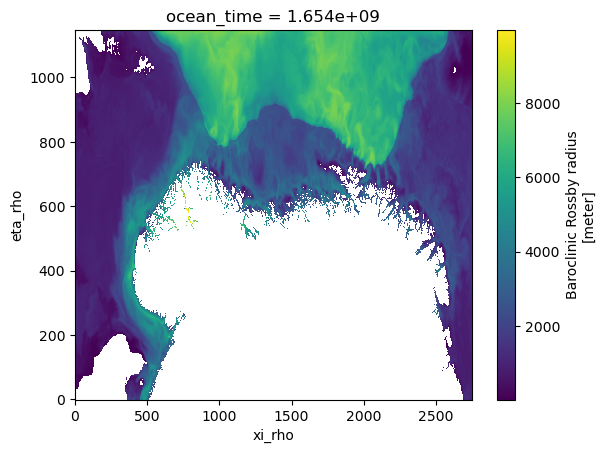

In [140]:
x.gamma_r.isel(ocean_time=0).plot()

In [119]:
from glob import glob

In [129]:
base_path = glob('/lustre/storeB/project/nwp/havvind/hav/results/reference/')
months = {
"02": 27,  # February
"03": 31,  # March
"04": 30,  # April
"05": 31,  # May
"06": 30   # June
}

In [130]:
base_path

['/lustre/storeB/project/nwp/havvind/hav/results/reference/']

In [ ]:


files = []

for month, days in months.items():
    for day in range(1, days + 1): 
        day_str = f"{day:04}"
        file_path = f'/REF-{month}/norkyst_avg_{day_str}.nc'
        
        

In [136]:
files[0]

'/lustre/storeB/project/nwp/havvind/hav/results/reference//REF-02/norkyst_avg_0001.nc'

In [135]:
# Original string
original_string = files[0]
# Extract parts using string methods
ref_part = original_string.split('reference//')[-1].split('/')[0].replace('-', '_')  # 'REF-02' to 'REF_02'
norkyst_part = original_string.split('/')[-1][:-3]  # Get 'norkyst_avg_0001' without '.nc'

# Combine to create the new string
new_string = f"{ref_part}_{norkyst_part}_brr.nc"
print(new_string)

REF_02_norkyst_avg_0001_brr.nc


In [137]:
testtt = '/home/kjsta7412/sommer_25/MET_sommer25/output_bdr/' + new_string

In [138]:
testtt

'/home/kjsta7412/sommer_25/MET_sommer25/output_bdr/REF_02_norkyst_avg_0001_brr.nc'

In [ ]:
mfile.split('/')[-1].replace('.nc',f'__brr.nc')

In [ ]:
    # Making a file to write to
outputf = f'/home/kjsta7412/sommer_25/MET_sommer25/output_bdr/{mfile.split("/")[-1].replace(".nc", f"_{month}_brr.nc")}'